# MGTA_415 Final Project: Fake News Detection

* Team member names:
    - David Yang
    - Jack Chen
* GitHub userid: rsm-day008, rsm-yuc172

### Load Required Modules And Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import string
import time

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, matthews_corrcoef, precision_score, recall_score

In [3]:
import os
os.getcwd()

'/home/jovyan/MGTA415_Unstructure Data/MGTA_415_Fake_News_Detection'

### Import Data

In [4]:
abs_path = 'data'
fake = pd.read_csv(abs_path + "/Fake.csv")
true = pd.read_csv(abs_path + "/True.csv")
test_set_fix = pd.read_csv('data/test.csv')
test_set_fix['label'] = np.where(test_set_fix['label']=='FAKE', 1, 0)
print('Fake news data: ',fake.shape)
print('True news data:',true.shape)
print('Test set data:',test_set_fix.shape)

Fake news data:  (23481, 4)
True news data: (21417, 4)
Test set data: (6335, 4)


In [5]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [7]:
test_set_fix.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",1
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,1
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,0
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,0


In [8]:
fake['class'] = 1
true['class'] = 0

In [9]:
train_set_fix = pd.concat([fake, true], axis=0)
train_set_fix.reset_index(inplace=True)
train_set_fix.drop(["index"], axis=1, inplace=True)
test_set_fix.drop(['Unnamed: 0'], axis=1, inplace=True)

In [10]:
train_set_fix.shape

(44898, 5)

In [11]:
train_set_fix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   class    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [12]:
train_set_fix.head()

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [13]:
# shuffle the dataset
train_set_fix = train_set_fix.sample(frac=1, random_state=42)

### Exploratory Data Analysis

In [14]:
class_counts = train_set_fix['class'].value_counts().sort_index()
class_counts

class
0    21417
1    23481
Name: count, dtype: int64

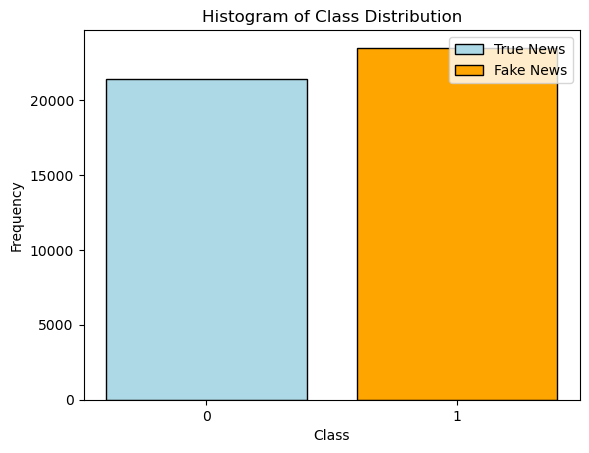

In [15]:
plt.bar(class_counts.index, class_counts.values, color=['#add8e6', '#ffa500'], edgecolor='black', label=['True News', 'Fake News'])

plt.legend(labels=['True News', 'Fake News'])
plt.xticks([0, 1])
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Histogram of Class Distribution')
plt.show()

In [16]:
subject_counts = train_set_fix['subject'].value_counts().sort_index()
subject_counts

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: count, dtype: int64

In [17]:
train_set_fix[train_set_fix['subject'] == 'worldnews']['class'].value_counts()

class
0    10145
Name: count, dtype: int64

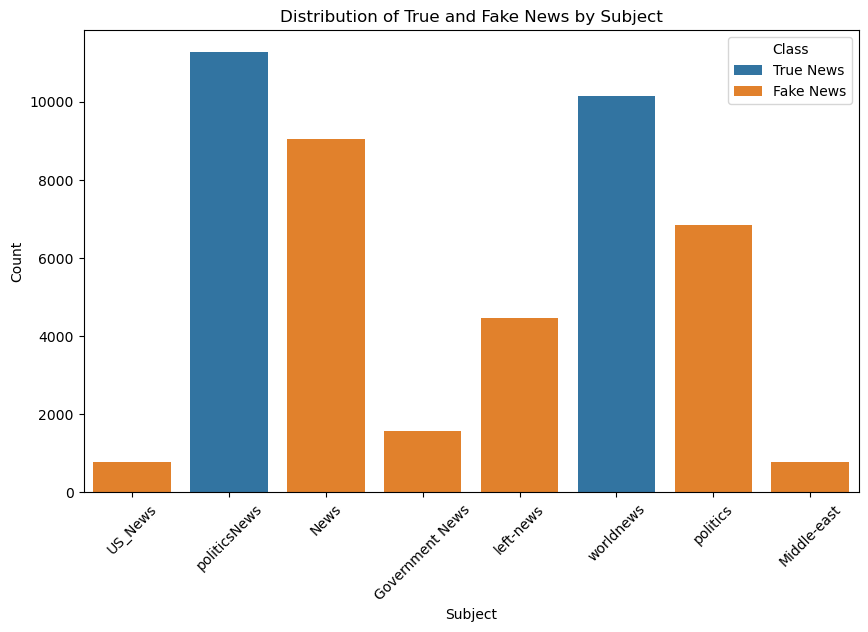

In [18]:
plt.figure(figsize=(10, 6))
sns.countplot(x='subject', hue='class', data=train_set_fix)

plt.title('Distribution of True and Fake News by Subject')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Class', labels=['True News', 'Fake News'])

plt.show()

We found that only subjects from "politicsNews" and "Worldnews" are true, while all other subjects are fake. \
Thus, using 'subject' feature to predict will lead to perfect prediction.

### Date Preprocessing

In [19]:
train_set = train_set_fix.copy()
test_set = test_set_fix.copy()

In [20]:
def process_news(text):
    text = text.lower()
    text = re.sub(r'https?://S+ | www\.\S+', '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub('\[.*?\]', '', text)
    words=[]
    for i in text:
        if i not in string.punctuation:
            words.append(i)
    return ''.join(words)

test_set['text'] = test_set['text'].apply(process_news)
train_set['text'] = train_set['text'].apply(process_news)
train_set['text'].head()

22216    21st century wire says ben stein reputable pro...
27917    washington reuters  us president donald trump ...
25007    reuters  puerto rico governor ricardo rossello...
1377     on monday donald trump once again embarrassed ...
32476    glasgow scotland reuters  most us presidential...
Name: text, dtype: object

In [21]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer

stop = set(stopwords.words('english'))
ps = PorterStemmer()

# Tokenization + Stemming + stop words removal 
def preprocess_stem_stop(doc, stemming=True, build_sent=False):
    tokens = []
    sentences = sent_tokenize(doc)
    for sent in sentences:
        words = word_tokenize(sent)
        if stemming:
            words = [ps.stem(word) for word in words]
        if build_sent:
            tokens.append(words)
        else:
            tokens += words
    return [w for w in tokens if w not in stop]

test_set['text'] = test_set['text'].apply(preprocess_stem_stop)
train_set['text'] = train_set['text'].apply(preprocess_stem_stop)
train_set['text'].head()

22216    [21st, centuri, wire, say, ben, stein, reput, ...
27917    [washington, reuter, us, presid, donald, trump...
25007    [reuter, puerto, rico, governor, ricardo, ross...
1377     [monday, donald, trump, onc, embarrass, hi, co...
32476    [glasgow, scotland, reuter, us, presidenti, ca...
Name: text, dtype: object

### Base ML models (only use 'text' feature)

In [22]:
x_train = train_set['text']
y_train = train_set['class']
x_test = test_set['text']
y_test = test_set['label']

In [23]:
# New var since stop words ans stemming took time
x_train_ = x_train.apply(lambda x: ' '.join(x))
x_test_ = x_test.apply(lambda x: ' '.join(x))  # This is for tfidf transformation below, since it only takes string as input. 


In [24]:
vector = TfidfVectorizer()
x_train_v = vector.fit_transform(x_train_)
x_test_v = vector.transform(x_test_)

## `Base Model - Logistic Regression`

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

logit = LogisticRegression(max_iter=50)
base_model = logit.fit(x_train_v, y_train)

predict_base = base_model.predict(x_test_v)

print("Accuracy: ", accuracy_score(y_test, predict_base))
print("Precision: ", precision_score(y_test, predict_base))
print("Recall: ", recall_score(y_test, predict_base))
print("F1-Score: ", f1_score(y_test, predict_base))
print("AUC: ", roc_auc_score(y_test, predict_base))

Accuracy:  0.5880031570639306
Precision:  0.5523233849641103
Recall:  0.9241466498103666
F1-Score:  0.6914164104989359
AUC:  0.5883741763715977


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Since the model performs poorly, re-consider Feature Engineering

In [26]:
train_set_eng = train_set_fix.copy()
test_set_eng = test_set_fix.copy()

In [27]:
def find_trump(text):
    if 'trump' in text.lower():
        return 1 
    else:  
        return 0

def find_obama(text):
    if 'obama' in text.lower():
        return 1 
    else:  
        return 0
    
def find_election(text):
    if 'election' in text.lower():
        return 1 
    else:  
        return 0

In [28]:
train_set_eng['is_trump'] = train_set_eng['text'].apply(find_trump)
test_set_eng['is_trump'] = test_set_eng['text'].apply(find_trump)

In [29]:
train_set_eng['is_obama'] = train_set_eng['text'].apply(find_obama)
test_set_eng['is_obama'] = test_set_eng['text'].apply(find_obama)

In [30]:
train_set_eng['is_election'] = train_set_eng['text'].apply(find_election)
test_set_eng['is_election'] = test_set_eng['text'].apply(find_election)

In [31]:
x_train_eng = train_set['text']
y_train = train_set['class']
x_test_eng = test_set['text']
y_test = test_set['label']

In [32]:
# New var since stop words ans stemming took time
x_train_eng = x_train_eng.apply(lambda x: ' '.join(x))
x_test_eng = x_test_eng.apply(lambda x: ' '.join(x))  # This is for tfidf transformation below, since it only takes string as input. 


In [33]:
vector = TfidfVectorizer()
x_train_eng = vector.fit_transform(x_train_eng)
x_test_eng = vector.transform(x_test_eng)

In [34]:
from scipy.sparse import hstack

# Stacking additional features with hstack (sparse matrix necessary)
x_train_eng = hstack([x_train_eng, train_set_eng[['is_trump', 'is_obama', 'is_election']]])
x_test_eng = hstack([x_test_eng, test_set_eng[['is_trump', 'is_obama', 'is_election']]])

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

logit = LogisticRegression(max_iter=50)
base_model = logit.fit(x_train_eng, y_train)

predict_base = base_model.predict(x_test_eng)

print("Accuracy: ", accuracy_score(y_test, predict_base))
print("Precision: ", precision_score(y_test, predict_base))
print("Recall: ", recall_score(y_test, predict_base))
print("F1-Score: ", f1_score(y_test, predict_base))
print("AUC: ", roc_auc_score(y_test, predict_base))

Accuracy:  0.5796369376479874
Precision:  0.5470953186689227
Recall:  0.9197218710493047
F1-Score:  0.6860780384298008
AUC:  0.5800123073316533


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [36]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    # Define the hyperparameter space
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', 'none'])
    C = trial.suggest_loguniform('C', 1e-4, 1e4)
    l1_ratio = None if penalty != 'elasticnet' else trial.suggest_uniform('l1_ratio', 0, 1)

    # Create the model with the suggested hyperparameters
    model = LogisticRegression(max_iter=50, penalty=penalty, C=C, solver='saga', l1_ratio=l1_ratio)

    # Perform cross-validation and return the average AUC score
    score = cross_val_score(model, x_train_eng, y_train, scoring='roc_auc', cv=5).mean()
    return score


In [37]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)  # Adjust n_trials to your preference

# Fetch the best parameters
best_params = study.best_params
print('Best parameters:', best_params)

# Train the model using the best parameters
best_model = LogisticRegression(**best_params, max_iter=50).fit(x_train_eng, y_train)

# Evaluate the best model
predict_best = best_model.predict(x_test_eng)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy: ", accuracy_score(y_test, predict_best))
print("Precision: ", precision_score(y_test, predict_best))
print("Recall: ", recall_score(y_test, predict_best))
print("F1-Score: ", f1_score(y_test, predict_best))
print("AUC: ", roc_auc_score(y_test, predict_best))


[I 2024-03-13 02:39:09,141] A new study created in memory with name: no-name-651c66c5-a7d1-4a02-88de-ffb682f0eee9
/tmp/ipykernel_32280/1109281076.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 1e4)
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/py

Best parameters: {'penalty': 'none', 'C': 0.031194266146534123}
Accuracy:  0.5641673243883188
Precision:  0.5368844956983343
Recall:  0.9269911504424779
F1-Score:  0.6799582705459604
AUC:  0.5645677921874956


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [38]:
rf = RandomForestClassifier()
rf_model = rf.fit(x_train_eng, y_train)

predict_rf = rf_model.predict(x_test_eng)

print("Accuracy: ", accuracy_score(y_test, predict_rf))
print("Precision: ", precision_score(y_test, predict_rf))
print("Recall: ", recall_score(y_test, predict_rf))
print("F1-Score: ", f1_score(y_test, predict_rf))
print("AUC: ", roc_auc_score(y_test, predict_rf))

Accuracy:  0.5717442778216258
Precision:  0.5460674157303371
Recall:  0.8448166877370418
F1-Score:  0.6633577366918973
AUC:  0.5720456822475811


In [42]:
from sklearn.linear_model import PassiveAggressiveClassifier

pac = PassiveAggressiveClassifier(max_iter=50)
pac_model = pac.fit(x_train_eng, y_train)

predict_pac = pac_model.predict(x_test_eng)

print("Accuracy: ", accuracy_score(y_test, predict_pac))
print("Precision: ", precision_score(y_test, predict_pac))
print("Recall: ", recall_score(y_test, predict_pac))
print("F1-Score: ", f1_score(y_test, predict_pac))


Accuracy:  0.5564325177584846
Precision:  0.5319148936170213
Recall:  0.9323640960809102
F1-Score:  0.677382319173364


In [39]:
# models = {
#     # 'Logistic Regression': LogisticRegression(),
#     'Decision Tree': DecisionTreeClassifier(),
#     # 'Random Forest': RandomForestClassifier(random_state=42),
#     # 'Gradient Classifier' : GradientBoostingClassifier(random_state=0)
# }

In [40]:
# for name, model in models.items():
#     start = time.time()
#     model.fit(xtrain, ytrain)
#     predict = model.predict(xtest)
    
#     LABELS = ['False', 'True']
#     conf_matrix = confusion_matrix(ytest, predict)
#     plt.figure(figsize =(6,5))
#     sns.heatmap(conf_matrix, xticklabels = LABELS, yticklabels = LABELS, vmax = 100, annot = True, fmt ="d");
#     plt.title(f'{name}')
#     plt.ylabel('True class')
#     plt.xlabel('Predicted class')
#     plt.show()
#     print("Accuracy: ", accuracy_score(ytest, predict))
#     print("Precision: ", precision_score(ytest, predict))
#     print("Recall: ", recall_score(ytest, predict))
#     print("F1-Score: ", f1_score(ytest, predict))
#     print("Matthews correlation coefficient: ", matthews_corrcoef(ytest, predict))
#     end = time.time()
#     print("Time taken(in sec): ",round(end-start, 2))
#     print('-' * 70, '\n')

### Further Study